In [6]:
import tensorflow
tensorflow.__version__

'2.8.0'

# Understanding recurrent neural networks

This notebook contains the code samples found in Chapter 6, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---

[...]

## A first recurrent layer in Keras

The process we just naively implemented in Numpy corresponds to an actual Keras layer: the `SimpleRNN` layer:


In [7]:
from tensorflow.keras.layers import SimpleRNN

There is just one minor difference: `SimpleRNN` processes batches of sequences, like all other Keras layers, not just a single sequence like 
in our Numpy example. This means that it takes inputs of shape `(batch_size, timesteps, input_features)`, rather than `(timesteps, 
input_features)`.

Like all recurrent layers in Keras, `SimpleRNN` can be run in two different modes: it can return either the full sequences of successive 
outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), or it can return only the last output for each 
input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor 
argument. Let's take a look at an example:

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


2022-04-13 22:19:49.227411: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. 
In such a setup, you have to get all intermediate layers to return full sequences:

In [10]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now let's try to use such a model on the IMDB movie review classification problem. First, let's preprocess the data:

In [11]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let's train a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer:

In [12]:
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 18s 107ms/step - loss: 0.5824 - acc: 0.6963 - val_loss: 0.6563 - val_acc: 0.6688
Epoch 2/10
157/157 [==============================] - 17s 106ms/step - loss: 0.3863 - acc: 0.8414 - val_loss: 0.3830 - val_acc: 0.8354
Epoch 3/10
157/157 [==============================] - 17s 107ms/step - loss: 0.2847 - acc: 0.8874 - val_loss: 0.4046 - val_acc: 0.8132
Epoch 4/10
157/157 [==============================] - 17s 108ms/step - loss: 0.2379 - acc: 0.9096 - val_loss: 0.3638 - val_acc: 0.8706
Epoch 5/10
157/157 [==============================] - 17s 109ms/step - loss: 0.1859 - acc: 0.9315 - val_loss: 0.3497 - val_acc: 0.8546
Epoch 6/10
157/157 [==============================] - 17s 111ms/step - loss: 0.1408 - acc: 0.9500 - val_loss: 0.4328 - val_acc: 0.8454
Epoch 7/10
157/157 [==============================] - 17s 109ms/step - loss: 0.0989 - acc: 0.9665 - val_loss: 0.4235 - val_acc: 0.8332
Epoch 8/10
157/157 [==============================] - 1

Let's display the training and validation loss and accuracy:

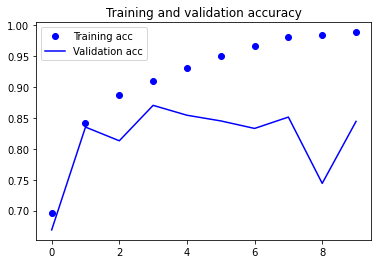

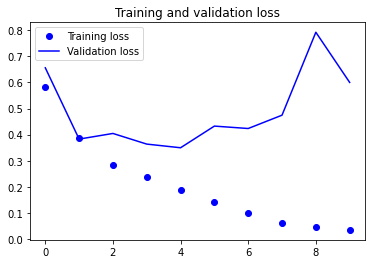

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As a reminder, in chapter 3, our very first naive approach to this very dataset got us to 88% test accuracy. Unfortunately, our small 
recurrent network doesn't perform very well at all compared to this baseline (only up to 85% validation accuracy). Part of the problem is 
that our inputs only consider the first 500 words rather the full sequences -- 
hence our RNN has access to less information than our earlier baseline model. The remainder of the problem is simply that `SimpleRNN` isn't very good at processing long sequences, like text. Other types of recurrent layers perform much better. Let's take a look at some 
more advanced layers.

[...]

## A concrete LSTM example in Keras

Now let's switch to more practical concerns: we will set up a model using a LSTM layer and train it on the IMDB data. Here's the network, 
similar to the one with `SimpleRNN` that we just presented. We only specify the output dimensionality of the LSTM layer, and leave every 
other argument (there are lots) to the Keras defaults. Keras has good defaults, and things will almost always "just work" without you 
having to spend time tuning parameters by hand.

In [14]:
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 38s 229ms/step - loss: 0.5210 - acc: 0.7512 - val_loss: 0.4888 - val_acc: 0.7758
Epoch 2/10
157/157 [==============================] - 36s 232ms/step - loss: 0.2948 - acc: 0.8845 - val_loss: 0.2981 - val_acc: 0.8782
Epoch 3/10
157/157 [==============================] - 39s 249ms/step - loss: 0.2325 - acc: 0.9139 - val_loss: 0.3190 - val_acc: 0.8628
Epoch 4/10
157/157 [==============================] - 43s 276ms/step - loss: 0.2039 - acc: 0.9259 - val_loss: 0.3504 - val_acc: 0.8702
Epoch 5/10
157/157 [==============================] - 42s 270ms/step - loss: 0.1782 - acc: 0.9352 - val_loss: 0.3411 - val_acc: 0.8700
Epoch 6/10
157/157 [==============================] - 41s 259ms/step - loss: 0.1640 - acc: 0.9388 - val_loss: 0.3309 - val_acc: 0.8806
Epoch 7/10
157/157 [==============================] - 41s 259ms/step - loss: 0.1476 - acc: 0.9471 - val_loss: 0.3162 - val_acc: 0.8770
Epoch 8/10
157/157 [==============================] - 3

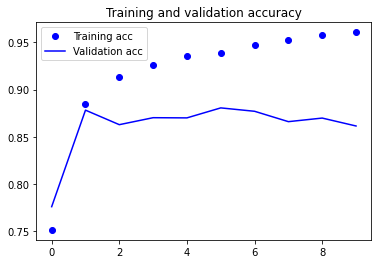

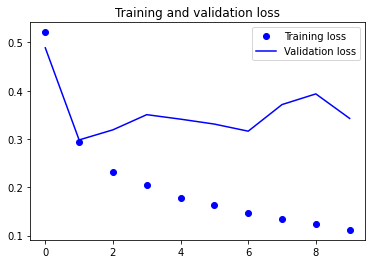

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Übung:
* Um beim Definieren und Trainieren eines LSTMs ein bisschen muscle memory zu entwickeln, schauen wir uns wieder den reuters-Datensatz an. Vielleicht können wir unser vorgestriges Ergebnis mit LSTMs schlagen?

In [16]:
from keras.datasets import reuters
from keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = reuters.load_data(num_words=max_features)
print(input_train.shape, 'train sequences')
print(input_test.shape, 'test sequences')

Loading data...
(8982,) train sequences
(2246,) test sequences


In [17]:
print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Pad sequences (samples x time)
input_train shape: (8982, 500)
input_test shape: (2246, 500)


# Lösung:

In [18]:
from keras.layers import LSTM, Flatten

model = Sequential()
model.add(Embedding(max_features, 32, input_length=maxlen))
model.add(LSTM(16, return_sequences=True))
model.add(LSTM(16, return_sequences=True))
model.add(Flatten())
#model.add(Dense(64, activation='relu'))
model.add(Dense(46, activation='softmax'))

model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 500, 32)           320000    
                                                                 
 lstm_1 (LSTM)               (None, 500, 16)           3136      
                                                                 
 lstm_2 (LSTM)               (None, 500, 16)           2112      
                                                                 
 flatten (Flatten)           (None, 8000)              0         
                                                                 
 dense_2 (Dense)             (None, 46)                368046    
                                                                 
Total params: 693,294
Trainable params: 693,294
Non-trainable params: 0
_________________________________________________________________


In [19]:

history = model.fit(
    input_train, 
    y_train,
    epochs=3,
    batch_size=128,
    validation_split=0.2
)

Epoch 1/3
57/57 [==============================] - 20s 312ms/step - loss: 2.2248 - acc: 0.4061 - val_loss: 1.7817 - val_acc: 0.5420
Epoch 2/3
57/57 [==============================] - 20s 349ms/step - loss: 1.6256 - acc: 0.5807 - val_loss: 1.6981 - val_acc: 0.5415
Epoch 3/3
57/57 [==============================] - 21s 360ms/step - loss: 1.3572 - acc: 0.6443 - val_loss: 1.3683 - val_acc: 0.6578


In [20]:
model.evaluate(input_test, y_test)

71/71 [==============================] - 3s 44ms/step - loss: 1.4207 - acc: 0.6354


[1.420654296875, 0.6353517174720764]